## Importe de librerias

In [2]:
import warnings

warnings.filterwarnings("ignore")

In [3]:
# Importar librerias
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt


%matplotlib inline

## Lectura de los datos

In [6]:
df_origin = pd.read_csv('https://raw.githubusercontent.com/jfelipeo/Proyecto_Analitica_II_Equipo-5/main/ecommerce-data.csv', sep=",")


Copia del DataFrame original para transformacion de datos

In [7]:
df_transformed = df_origin.copy()
df_transformed = df_transformed.drop_duplicates()

Cambio de tipos a las variables que deben ser categóricas y las numericas para conservar el mismo formato.

In [8]:
df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']] = df_transformed[['OperatingSystems', 'Browser', 'Region', 'TrafficType']].astype('object')
df_transformed[['Reviews','Informational','ProductRelated']] = df_transformed[['Reviews','Informational','ProductRelated']].astype('float')

In [9]:
df_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Reviews                  12205 non-null  float64
 1   Reviews_Duration         12205 non-null  float64
 2   Informational            12205 non-null  float64
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  float64
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  object 
 12  Browser                  12205 non-null  object 
 13  Region                   12205 non-null  object 
 14  TrafficType              12

Eliminación de las variables relacionadas con el tiempo (duracion), de acuerdo al analisis exploratorio de los datos.

In [10]:
cols_delete = ['Reviews_Duration', 'Informational_Duration','ProductRelated_Duration']
df_depured= df_transformed.drop(cols_delete, axis=1)
df_depured.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12205 entries, 0 to 12329
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Reviews           12205 non-null  float64
 1   Informational     12205 non-null  float64
 2   ProductRelated    12205 non-null  float64
 3   BounceRates       12205 non-null  float64
 4   ExitRates         12205 non-null  float64
 5   PageValues        12205 non-null  float64
 6   SpecialDay        12205 non-null  float64
 7   Month             12205 non-null  object 
 8   OperatingSystems  12205 non-null  object 
 9   Browser           12205 non-null  object 
 10  Region            12205 non-null  object 
 11  TrafficType       12205 non-null  object 
 12  VisitorType       12205 non-null  object 
 13  Weekend           12205 non-null  bool   
 14  Purchase          12205 non-null  bool   
dtypes: bool(2), float64(7), object(6)
memory usage: 1.3+ MB


In [16]:
df_depured.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Reviews,12205.0,2.338878,3.330436,0.0,0.000000,1.000000,4.000000,27.000000
Informational,12205.0,0.508726,1.275617,0.0,0.000000,0.000000,0.000000,24.000000
ProductRelated,12205.0,32.045637,44.593649,0.0,8.000000,18.000000,38.000000,705.000000
BounceRates,12205.0,0.020370,0.045255,0.0,0.000000,0.002899,0.016667,0.200000
ExitRates,12205.0,0.041466,0.046163,0.0,0.014231,0.025000,0.048529,0.200000
PageValues,12205.0,5.949574,18.653671,0.0,0.000000,0.000000,0.000000,361.763742
SpecialDay,12205.0,0.061942,0.199666,0.0,0.000000,0.000000,0.000000,1.000000


## Separación de variable objetivo y caracteristicas

In [17]:
# Con los datos originales
y = df_depured.Purchase
X = df_depured.drop(['Purchase'], axis=1)

Dumminizado de variables categóricas

In [18]:
X_dummys = pd.get_dummies(X)
X_dummys.head()

,Reviews,Informational,ProductRelated,BounceRates,ExitRates,PageValues,SpecialDay,Weekend,Month_Aug,Month_Dec,...,TrafficType_14,TrafficType_15,TrafficType_16,TrafficType_17,TrafficType_18,TrafficType_19,TrafficType_20,VisitorType_New_Visitor,VisitorType_Other,VisitorType_Returning_Visitor
0,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,0.0,0.0,2.0,0.00,0.10,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,0.0,0.0,1.0,0.20,0.20,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,0.0,0.0,2.0,0.05,0.14,0.0,0.0,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,0.0,0.0,10.0,0.02,0.05,0.0,0.0,True,False,False,...,False,False,False,False,False,False,False,False,False,True


Codificación de la variable objetivo

In [19]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

print(y[:10])
print(le.classes_)

[0 0 0 0 0 0 0 0 0 0]
[False  True]


## Prueba transformando atípicos extremos

Revisión de los datos atípicos extremos

In [20]:
# Diccionario de valores límite para cada columna
valores_limite = {'Reviews': 25, 'Informational': 15, 'ProductRelated': 450, 'BounceRates':0.2, 'ExitRates': 0.2, 'PageValues': 150}

# Conteo de datos
conteos = {}

# Iteraracion y busqueda
for columna, limite in valores_limite.items():
    # Filtrar los datos de la columna que sean mayores o iguales al valor límite
    datos_filtrados = X_dummys[X_dummys[columna] >= limite][columna]
    # Contar el número de filas encontradas
    conteo = datos_filtrados.count()
    # Almacenar el conteo en el diccionario
    conteos[columna] = conteo

# Mostrar los conteos para cada columna
for columna, conteo in conteos.items():
    print("Datos mayores o iguales a", valores_limite[columna], "en la columna", columna + ":", conteo)

Datos mayores o iguales a 25 en la columna Reviews: 2
Datos mayores o iguales a 15 en la columna Informational: 2
Datos mayores o iguales a 450 en la columna ProductRelated: 9
Datos mayores o iguales a 0.2 en la columna BounceRates: 575
Datos mayores o iguales a 0.2 en la columna ExitRates: 585
Datos mayores o iguales a 150 en la columna PageValues: 27


In [21]:
df_X_dummys_outliers = X_dummys.copy()
columnas_numericas = df_X_dummys_outliers.select_dtypes(include=np.number)
medianas = columnas_numericas.median()

# Iterar sobre las columnas y valores límite
for columna, limite in valores_limite.items():
    # Filtrar los datos de la columna que sean mayores o iguales al valor límite
    indices_filtrados = df_X_dummys_outliers[columna] >= limite
    # Reemplazar los valores que cumplen la condición por la mediana de esa columna
    df_X_dummys_outliers.loc[indices_filtrados, columna] = medianas[columna]

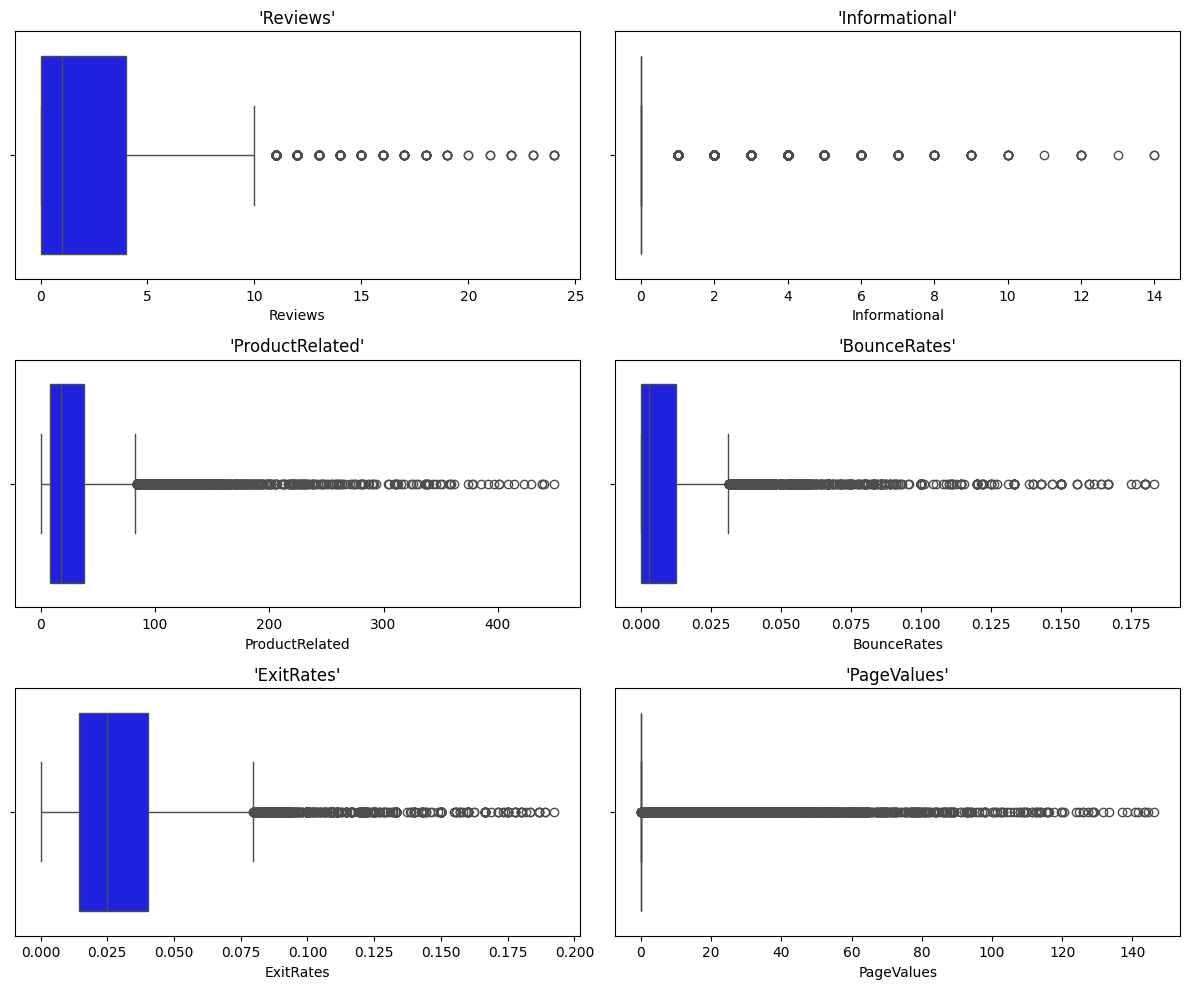

In [22]:
variables_numericas = ['Reviews', 'Informational', 'ProductRelated',
                       'BounceRates',
                       'ExitRates', 'PageValues']

num_variables = len(variables_numericas)
num_filas = (num_variables + 1) // 2
num_columnas = 2

fig, axes = plt.subplots(num_filas, num_columnas, figsize=(12, 10))
axes = axes.flatten()

for i, variable in enumerate(variables_numericas):
    sns.boxplot(x=df_X_dummys_outliers[variable], ax=axes[i], color='Blue')
    axes[i].set_title(f"'{variable}'")
    #axes[i].set_xlabel()

plt.tight_layout()
plt.show()

## Selección de variables por el metodo de Wrapper

Ejecutando con RFE

In [26]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Función recursiva de selección de características
def recursive_feature_selection(X,y,model,k):
  rfe = RFE(model, n_features_to_select=k, step=1)
  fit = rfe.fit(X, y)
  X_new = fit.support_
  print("Num Features: %s" % (fit.n_features_))
  print("Selected Features: %s" % (fit.support_))
  print("Feature Ranking: %s" % (fit.ranking_))

  return X_new

In [24]:
# Establecer Estimador
model = LogisticRegression(max_iter=300)
# Obtener columnas seleciconadas - (10 caracteristicas)
X_new_class = recursive_feature_selection(X_dummys, y, model, 10)
# Nuevo conjunto de datos
df_classification_new = X_dummys.iloc[:,X_new_class]
df_classification_new.head()

Num Features: 10
Selected Features: [False False False  True  True False  True False False False  True False
 False False False  True False False False False False False False False
 False False False False  True False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False False False False False False
  True False  True False False  True False False False False False]
Feature Ranking: [52 31 62  1  1 39  1 35  6 22  1  8 29 16 38  1  4  5 45 20  9 46 44 21
 18 23 30 27  1 28 61 19 17 48 53 40 43  1 42 58 25 50 41 37 55 49 60 24
  3 33  2 57 36 12  7 15 56 32 34 51  1 47  1 13 54  1 10 11 59 26 14]


,BounceRates,ExitRates,SpecialDay,Month_Feb,Month_Nov,Browser_3,Browser_12,TrafficType_13,TrafficType_15,TrafficType_18
0,0.20,0.20,0.0,True,False,False,False,False,False,False
1,0.00,0.10,0.0,True,False,False,False,False,False,False
2,0.20,0.20,0.0,True,False,False,False,False,False,False
3,0.05,0.14,0.0,True,False,False,False,False,False,False
4,0.02,0.05,0.0,True,False,True,False,False,False,False


Ejecutando con "SequentialFeatureSelector" (el que usaremos dado que el anterior no tuvo encuenta la variable "PageValues" dada la importancia en la misma con la variable objetivo)

In [27]:
from sklearn.feature_selection import SequentialFeatureSelector

# Selector secuencias utilizando regresión logistica - clasificación
sfs = SequentialFeatureSelector(LogisticRegression(max_iter=300),
                                n_features_to_select=5,
                                direction= "forward",
                                scoring='recall')

# Obtener variable seleccionadas
sfs = sfs.fit(X_dummys, y)
X_new_class = sfs.support_
df_classification_new = X_dummys.iloc[:,X_new_class]
df_classification_new.head()

,PageValues,Month_Dec,Month_Mar,Month_May,VisitorType_New_Visitor
0,0.0,False,False,False,False
1,0.0,False,False,False,False
2,0.0,False,False,False,False
3,0.0,False,False,False,False
4,0.0,False,False,False,False


# Desbalanceo de Clases

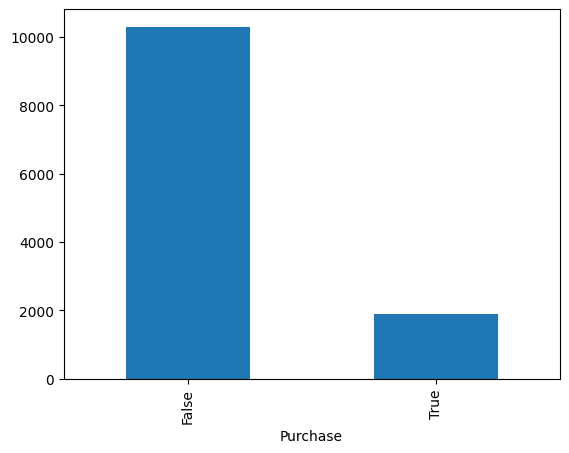

In [14]:
# Identificación de ejemplos de entrenamiento por clases
df_depured['Purchase'].value_counts().plot(kind='bar');



Por tratarse de un desbalanceo, vamos a realizar el submuestreo aleatorio con imblearn

In [33]:
# importar libreria
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

sub = RandomUnderSampler(random_state=142) 
# fit predictor and target variable
###X_sub, y_sub = sub.fit_resample(X_dummys, y)
X_sub, y_sub = sub.fit_resample(X_dummys, y)
print('original dataset shape:', Counter(y))
print('Resample dataset shape', Counter(y_sub))

original dataset shape: Counter({0: 10297, 1: 1908})
Resample dataset shape Counter({0: 1908, 1: 1908})


O por sobremuestreo

In [54]:
# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=42)

# # fit predictor and target variablex_ros, y_ros = ros.fit_resample(x, y)
# X_sub, y_sub = ros.fit_resample(X_dummys, y)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_sub))

Original dataset shape Counter({0: 10297, 1: 1908})
Resample dataset shape Counter({0: 10297, 1: 10297})


# Modelado: Aplicación de técnicas de ML

## Modelo 1: Decision Tree Classifier



In [63]:

# split de datos originales en train y test
X_train, X_test, y_train, y_test = train_test_split(X_dummys, y, test_size=0.2,random_state=142)

# split de datos originales sin outliers en train y test
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(df_X_dummys_outliers, y, test_size=0.2,random_state=142)

# split de datos con seleccion de caracteristicas "Wrapper" en train y test
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(df_classification_new, y, test_size=0.2,random_state=142)

### Modelo 1.1: Decision Tree Classifier con datos originales sin balancear

In [54]:
# Entrenamiento del modelo

clf = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=142, 
          #class_weight='balanced'
          )
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=142)

In [52]:
# Entrenamiento del modelo sin outliers

clf_so = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=142, 
          #class_weight='balanced'
          )
clf_so.fit(X_train_so, y_train_so)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=142)

### Metricas de desempeño

In [62]:
# Métricas de desempeño Originales
# ==============================================================================
print ("Train Original - Accuracy :", metrics.accuracy_score(y_train, clf.predict(X_train)))
print ("Train Original - classification report:\n", metrics.classification_report(y_train, clf.predict(X_train), digits=4))
print ("Test Original - Accuracy :", metrics.accuracy_score(y_test, clf.predict(X_test)))
print ("Test Original - classification report:\n", metrics.classification_report(y_test, clf.predict(X_test), digits=4))

print("==============================================================================")
print ("Train sin Outliers - Accuracy :", metrics.accuracy_score(y_train_so, clf_so.predict(X_train_so)))
print ("Train sin Outliers - classification report:\n", metrics.classification_report(y_train_so, clf_so.predict(X_train_so), digits=4))
print ("Test sin Outliers - Accuracy :", metrics.accuracy_score(y_test_so, clf_so.predict(X_test_so)))
print ("Test sin Outliers - classification report:\n", metrics.classification_report(y_test_so, clf_so.predict(X_test_so), digits=4))


Train Original - Accuracy : 0.903113478082753
Train Original - classification report:
               precision    recall  f1-score   support

           0     0.9193    0.9707    0.9443      8261
           1     0.7675    0.5316    0.6281      1503

    accuracy                         0.9031      9764
   macro avg     0.8434    0.7512    0.7862      9764
weighted avg     0.8959    0.9031    0.8956      9764

Test Original - Accuracy : 0.9000409668168783
Test Original - classification report:
               precision    recall  f1-score   support

           0     0.9118    0.9745    0.9421      2036
           1     0.8038    0.5259    0.6358       405

    accuracy                         0.9000      2441
   macro avg     0.8578    0.7502    0.7889      2441
weighted avg     0.8938    0.9000    0.8913      2441

Train sin Outliers - Accuracy : 0.9018844735764031
Train sin Outliers - classification report:
               precision    recall  f1-score   support

           0     0.917

Al realizar la comparación de datos originales con outliers y sin outliers, vemos que al tratamiento de estos no tiene mayor incidencia, de echo reduce un poco las metricas de desempeño, por lo tanto se toma la desición de seguir el resto de modelos con la base de datos original sin tratamiento de outliers extremos.

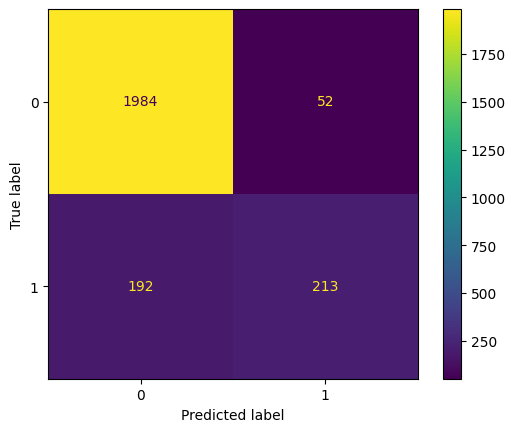

In [43]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm= confusion_matrix(y_test, clf.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

### Modelo 1.2: Decision Tree Classifier con datos originales con balanceo manual

In [44]:
# Entrenamiento del modelo

clf_1 = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=142, 
          #class_weight='balanced'
          )
clf_1.fit(X_sub, y_sub)

DecisionTreeClassifier(max_depth=6, max_leaf_nodes=10, random_state=142)

### Metricas de desempeño

In [45]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, clf_1.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, clf_1.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, clf_1.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, clf_1.predict(X_test), digits=4))

Train - Accuracy : 0.8502662843097092
Train - classification report:
               precision    recall  f1-score   support

           0     0.9716    0.8478    0.9055      8261
           1     0.5080    0.8636    0.6397      1503

    accuracy                         0.8503      9764
   macro avg     0.7398    0.8557    0.7726      9764
weighted avg     0.9002    0.8503    0.8646      9764

Test - Accuracy : 0.8570258090946333
Test - classification report:
               precision    recall  f1-score   support

           0     0.9663    0.8585    0.9092      2036
           1     0.5443    0.8494    0.6635       405

    accuracy                         0.8570      2441
   macro avg     0.7553    0.8540    0.7863      2441
weighted avg     0.8963    0.8570    0.8685      2441



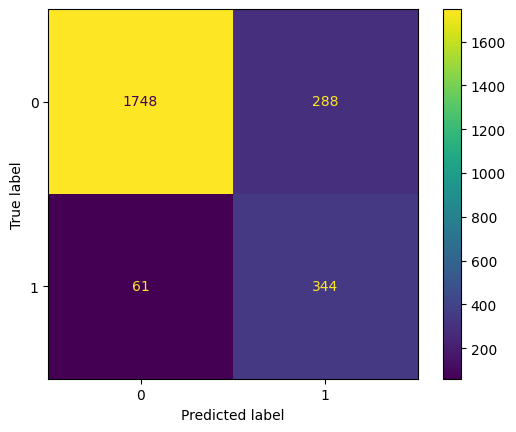

In [46]:
# Matriz de confusion
cm1= confusion_matrix(y_test, clf_1.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm_display.plot()
plt.show()

### Modelo 1.3: Decision Tree Classifier con datos originales con balanceo "class_weight"

In [47]:
# Entrenamiento del modelo

clf_2 = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=142, 
          class_weight='balanced'
          )
clf_2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=10,
                       random_state=142)

In [48]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, clf_2.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, clf_2.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, clf_2.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, clf_2.predict(X_test), digits=4))

Train - Accuracy : 0.847501024170422
Train - classification report:
               precision    recall  f1-score   support

           0     0.9721    0.8440    0.9035      8261
           1     0.5027    0.8669    0.6364      1503

    accuracy                         0.8475      9764
   macro avg     0.7374    0.8554    0.7700      9764
weighted avg     0.8999    0.8475    0.8624      9764

Test - Accuracy : 0.8512904547316673
Test - classification report:
               precision    recall  f1-score   support

           0     0.9660    0.8517    0.9052      2036
           1     0.5325    0.8494    0.6546       405

    accuracy                         0.8513      2441
   macro avg     0.7493    0.8505    0.7799      2441
weighted avg     0.8941    0.8513    0.8637      2441



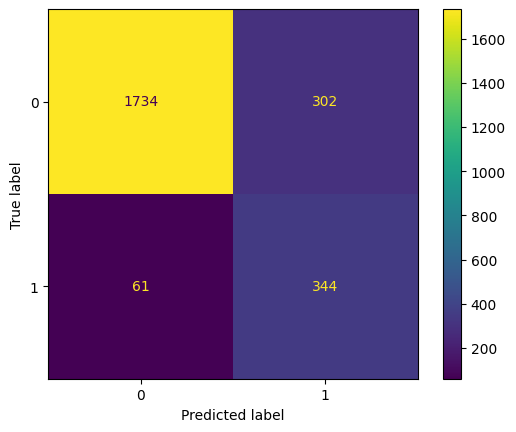

In [49]:
# Matriz de confusion
cm2= confusion_matrix(y_test, clf_2.predict(X_test))
# Visualización de la matriz de confusion
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm2)
cm_display.plot()
plt.show()

### Modelo 1.4: Decision Tree Classifier con seleccion de variables Wrapper

In [65]:
# Entrenamiento del modelo

clf_3 = tree.DecisionTreeClassifier(
          criterion = 'gini',
          max_depth = 6,
          max_leaf_nodes=10,
          random_state=142, 
          class_weight='balanced'
          )
clf_3.fit(X_train_sc, y_train_sc)

DecisionTreeClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=10,
                       random_state=142)

In [66]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train_sc, clf_3.predict(X_train_sc)))
print ("Train - classification report:\n", metrics.classification_report(y_train_sc, clf_3.predict(X_train_sc), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test_sc, clf_3.predict(X_test_sc)))
print ("Test - classification report:\n", metrics.classification_report(y_test_sc, clf_3.predict(X_test_sc), digits=4))

Train - Accuracy : 0.8757681278164686
Train - classification report:
               precision    recall  f1-score   support

           0     0.9619    0.8884    0.9237      8261
           1     0.5679    0.8064    0.6665      1503

    accuracy                         0.8758      9764
   macro avg     0.7649    0.8474    0.7951      9764
weighted avg     0.9012    0.8758    0.8841      9764

Test - Accuracy : 0.876689881196231
Test - classification report:
               precision    recall  f1-score   support

           0     0.9578    0.8915    0.9234      2036
           1     0.5952    0.8025    0.6835       405

    accuracy                         0.8767      2441
   macro avg     0.7765    0.8470    0.8035      2441
weighted avg     0.8976    0.8767    0.8836      2441



### RESUMEN: Captura de resultado "Recall" de los modelos con "Decision Tree Classifier"

In [80]:
from sklearn.metrics import recall_score

def calcular_recall_para_modelos(model_name, modelos, conjuntos_X, conjuntos_X_test, objetivos_y_train, objetivos_y_test):
    train_recalls = []
    test_recalls = []

    for clf, X, X_test, y_train, y_test in zip(modelos, conjuntos_X, conjuntos_X_test, objetivos_y_train, objetivos_y_test):
        train_recall = recall_score(y_train, clf.predict(X))
        test_recall = recall_score(y_test, clf.predict(X_test))
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)

    df = pd.DataFrame({
        'Modelo': model_name,
        'Train Recall': train_recalls,
        'Test Recall': test_recalls
    })

    return df

# Utiliza la función con tus modelos y datos
model_name = ["DTF orig. sin balanceo","DTF orig. balanc. manual","DTF orig. balanc. class weight ","DTF seleccion variables"]
modelos = [clf, clf_1, clf_2, clf_3]
conjuntos_X = [X_train, X_train, X_train, X_train_sc]
conjuntos_X_test = [X_test, X_test, X_test, X_test_sc]
y_train_list = [y_train, y_train, y_train, y_train]  # Lista de y_train para cada modelo
y_test_list = [y_test, y_test, y_test, y_test]  # Lista de y_test para cada modelo

df_recall = calcular_recall_para_modelos(model_name, modelos, conjuntos_X, conjuntos_X_test, y_train_list, y_test_list)
df_recall

,Modelo,Train Recall,Test Recall
0,DTF orig. sin balanceo,0.531603,0.525926
1,DTF orig. balanc. manual,0.863606,0.849383
2,DTF orig. balanc. class weight,0.866933,0.849383
3,DTF seleccion variables,0.806387,0.802469


### Gráfico Arbol de la mejor métrica

Profundidad del árbol: 5
Número de nodos terminales: 10


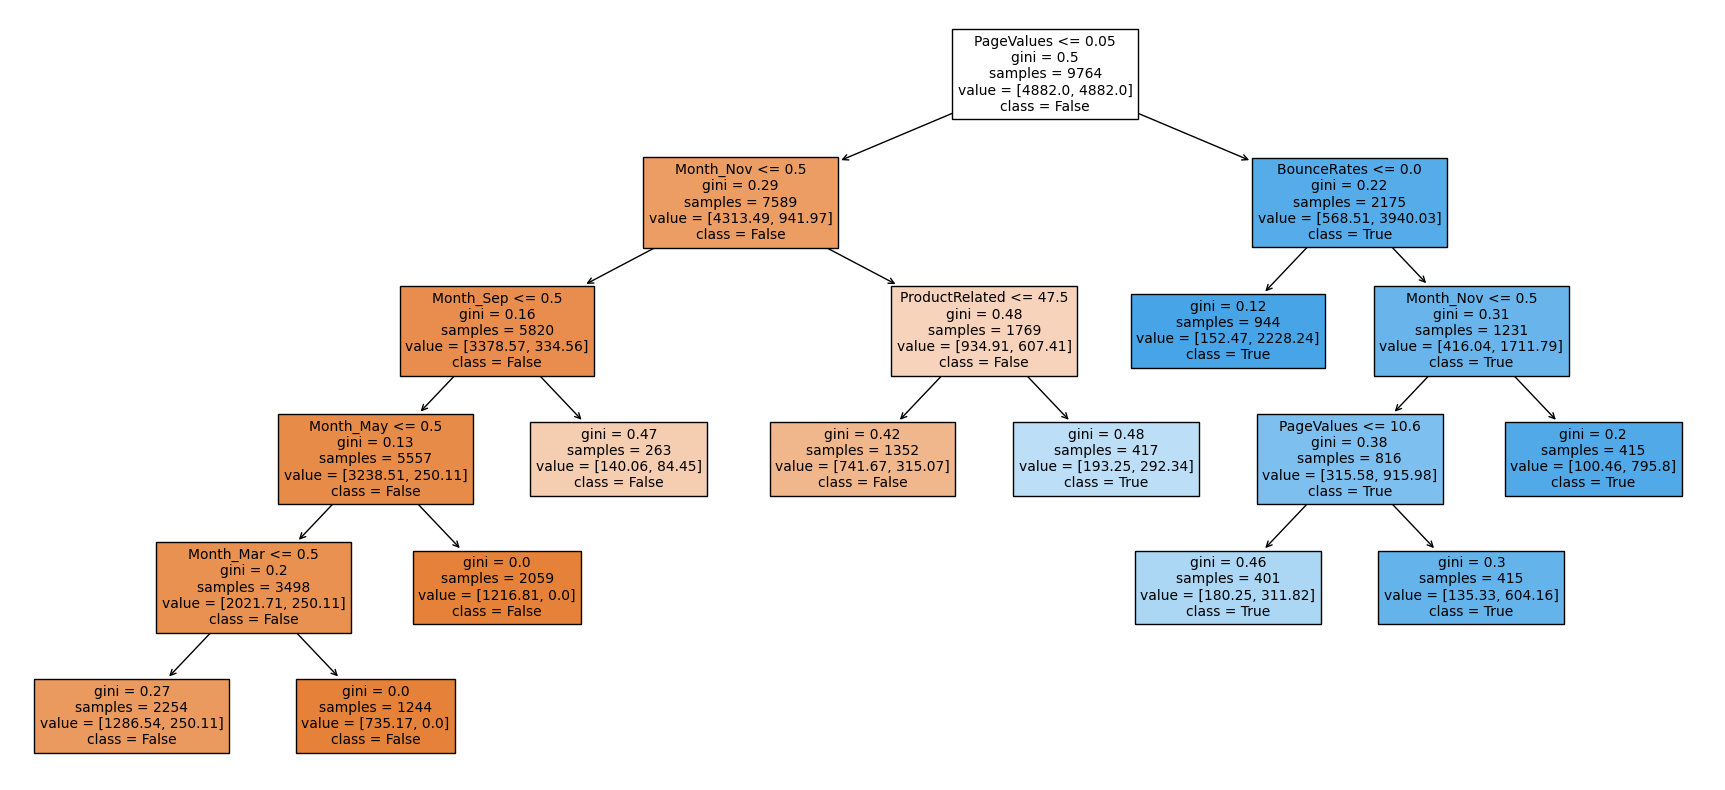

In [84]:
# Visualización del arbol

from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(22, 10))

print(f"Profundidad del árbol: {clf_2.get_depth()}")
print(f"Número de nodos terminales: {clf_2.get_n_leaves()}")

plot = plot_tree(
            decision_tree = clf_2,
            feature_names = X_dummys.columns.tolist(),
            class_names   = ['False', 'True'],
            filled        = True,
            impurity      = True,
            fontsize      = 10,
            precision     = 2,
            ax            = ax
       )

# Modelo 2: Random Forest Classifier

In [90]:
from sklearn.ensemble import RandomForestClassifier
# Entrenamiento del modelo

ranfor = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            max_depth    = 6,
            max_leaf_nodes = 10,
            n_jobs       = -1,
            random_state = 142,
            class_weight = 'balanced'
         )
ranfor.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, max_leaf_nodes=10,
                       n_estimators=150, n_jobs=-1, random_state=142)

In [91]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor.predict(X_test), digits=4))

Train - Accuracy : 0.8573330602212208
Train - classification report:
               precision    recall  f1-score   support

           0     0.9689    0.8590    0.9106      8261
           1     0.5225    0.8483    0.6467      1503

    accuracy                         0.8573      9764
   macro avg     0.7457    0.8536    0.7787      9764
weighted avg     0.9002    0.8573    0.8700      9764

Test - Accuracy : 0.8562064727570667
Test - classification report:
               precision    recall  f1-score   support

           0     0.9622    0.8615    0.9090      2036
           1     0.5437    0.8296    0.6569       405

    accuracy                         0.8562      2441
   macro avg     0.7529    0.8456    0.7830      2441
weighted avg     0.8927    0.8562    0.8672      2441



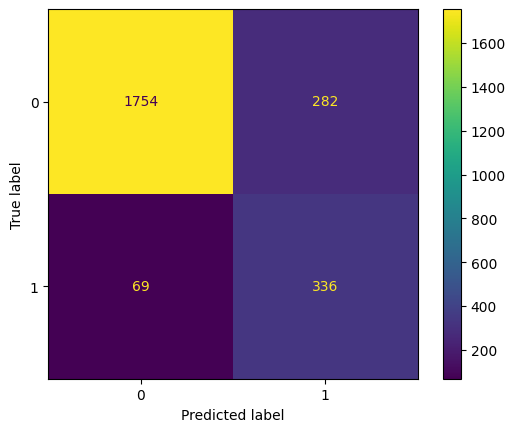

In [92]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm1= confusion_matrix(y_test, ranfor.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

# Modelo 3: Tunning de Hiperparámetros

## RandomForest

In [93]:
# Importe de libreria
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [94]:
## Definir cuadricula de búsqueda
# =================================================
parameters = {
    'max_depth': [None,5,10,15,20],
    'max_features': [0.6, 0.8, 1],
    'max_leaf_nodes': [6,8,10,12,14],
    'min_samples_leaf': [6,8,10,12,14],
    'n_estimators': [100,150,200,250,300]
}

In [95]:
# Modelo para tunning
ranfor_s = RandomForestClassifier(
    criterion = 'gini',
    n_jobs = -1,
    random_state= 142,
    class_weight = 'balanced'
)

In [142]:
# Búsqueda aleatoria

# Definición de cuadricula de búsqueda 
rand_s = RandomizedSearchCV(ranfor_s, param_distributions=parameters, n_iter=20, scoring='f1', cv=5, verbose=True) #'roc_auc'

# Iniciar la búsqueda
rand_s.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(class_weight='balanced',
                                                    n_jobs=-1,
                                                    random_state=142),
                   n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 15, 20],
                                        'max_features': [0.6, 0.8, 1],
                                        'max_leaf_nodes': [6, 8, 10, 12, 14],
                                        'min_samples_leaf': [6, 8, 10, 12, 14],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   scoring='f1', verbose=True)

In [143]:
print('Mejores Hiperparámetros: ', rand_s.best_params_)
print('Mejor Score: ', rand_s.best_score_)

Mejores Hiperparámetros:  {'n_estimators': 100, 'min_samples_leaf': 12, 'max_leaf_nodes': 6, 'max_features': 0.6, 'max_depth': 5}
Mejor Score:  0.6492359328113848


In [144]:
# Métricas de desempeño
ranfor_optimo = rand_s.best_estimator_
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor_optimo.predict(X_test), digits=4))

Train - Accuracy : 0.8621466612044244
Train - classification report:
               precision    recall  f1-score   support

           0     0.9679    0.8658    0.9140      8261
           1     0.5331    0.8423    0.6529      1503

    accuracy                         0.8621      9764
   macro avg     0.7505    0.8540    0.7835      9764
weighted avg     0.9010    0.8621    0.8738      9764

Test - Accuracy : 0.8656288406390823
Test - classification report:
               precision    recall  f1-score   support

           0     0.9626    0.8728    0.9155      2036
           1     0.5647    0.8296    0.6720       405

    accuracy                         0.8656      2441
   macro avg     0.7637    0.8512    0.7938      2441
weighted avg     0.8966    0.8656    0.8751      2441



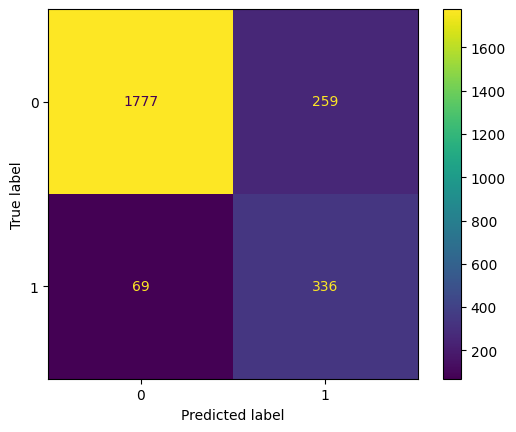

In [145]:
# Matriz de confusion
cm2= confusion_matrix(y_test, ranfor_optimo.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm2)
cm1_display.plot()
plt.show()

# Modelo 4: Gradient Boosting Classifier

In [132]:
from sklearn.ensemble import GradientBoostingClassifier

gboos = GradientBoostingClassifier(
            n_estimators = 100,
            learning_rate= 0.1,
            max_depth = 4,
            random_state = 142            
         )
gboos.fit(X_sub, y_sub)


GradientBoostingClassifier(max_depth=4, random_state=142)

In [133]:
# Métricas de desempeño

print ("Train - Accuracy :", metrics.accuracy_score(y_train, gboos.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, gboos.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, gboos.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, gboos.predict(X_test), digits=4))

Train - Accuracy : 0.8719786972552233
Train - classification report:
               precision    recall  f1-score   support

           0     0.9792    0.8671    0.9197      8261
           1     0.5517    0.8989    0.6837      1503

    accuracy                         0.8720      9764
   macro avg     0.7654    0.8830    0.8017      9764
weighted avg     0.9134    0.8720    0.8834      9764

Test - Accuracy : 0.876689881196231
Test - classification report:
               precision    recall  f1-score   support

           0     0.9774    0.8723    0.9219      2036
           1     0.5833    0.8988    0.7075       405

    accuracy                         0.8767      2441
   macro avg     0.7804    0.8855    0.8147      2441
weighted avg     0.9120    0.8767    0.8863      2441



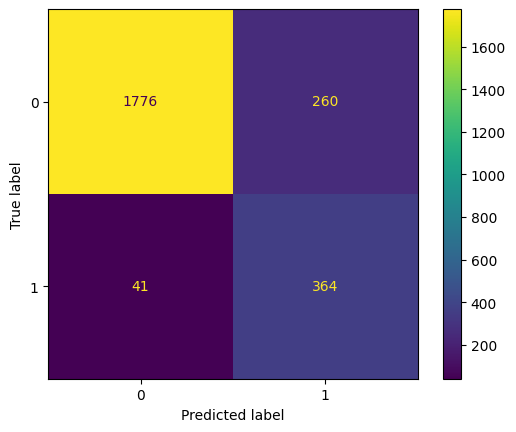

In [134]:
# Matriz de confusion
cm1= confusion_matrix(y_test, gboos.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

# Modelo 5: Gradient Boosting Classifier Tunning hiperparametros

In [146]:
# Cuadricula de hiperparametros

parametersGBC = {'learning_rate': [0.05, 0.1,0.3],
              'max_features': [2, 4, 6, 8],
              'max_depth': [4,6,8,10,12],
              'n_estimators': [80, 100, 150, 200]}

In [147]:
#Definición del modelo
from sklearn.ensemble import GradientBoostingClassifier
ranfor_GBC = GradientBoostingClassifier(random_state = 142)

SearchCV_GBC = RandomizedSearchCV(
    ranfor_GBC,
    parametersGBC,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Iniciamos la busqueda
grid_result = SearchCV_GBC.fit(X_sub, y_sub)

print('Mejores Hiperparámetros: ', grid_result.best_params_)
print('Mejor Score: ', grid_result.best_score_)

Mejores Hiperparámetros:  {'n_estimators': 80, 'max_features': 8, 'max_depth': 12, 'learning_rate': 0.3}
Mejor Score:  0.753998038628076


In [148]:
# Métricas de desempeño
ranfor_optimo_GBC = grid_result.best_estimator_
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo_GBC.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo_GBC.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo_GBC.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor_optimo_GBC.predict(X_test), digits=4))

Train - Accuracy : 0.882425235559197
Train - classification report:
               precision    recall  f1-score   support

           0     1.0000    0.8610    0.9253      8261
           1     0.5670    1.0000    0.7236      1503

    accuracy                         0.8824      9764
   macro avg     0.7835    0.9305    0.8245      9764
weighted avg     0.9333    0.8824    0.8943      9764

Test - Accuracy : 0.8897992625972961
Test - classification report:
               precision    recall  f1-score   support

           0     1.0000    0.8679    0.9293      2036
           1     0.6009    1.0000    0.7507       405

    accuracy                         0.8898      2441
   macro avg     0.8004    0.9339    0.8400      2441
weighted avg     0.9338    0.8898    0.8996      2441



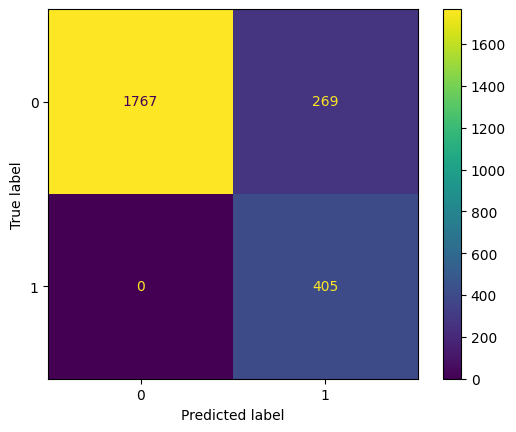

In [149]:
# Matriz de confusion
cm3= confusion_matrix(y_test, ranfor_optimo_GBC.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm3)
cm1_display.plot()
plt.show()

# Modelo 6: XGB Classifier

In [150]:
#%pip install xgboost
from xgboost import XGBClassifier


xgb = XGBClassifier(
    n_estimators = 100,
    learning_rate= 0.1,
    max_depth = 4,
    random_state = 142
)
xgb.fit(X_sub, y_sub)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=142, ...)

In [151]:
# Métricas de desempeño
# ==============================================================================
print ("Train - Accuracy :", metrics.accuracy_score(y_train, xgb.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, xgb.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, xgb.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, xgb.predict(X_test), digits=4))

Train - Accuracy : 0.8673699303564113
Train - classification report:
               precision    recall  f1-score   support

           0     0.9754    0.8650    0.9169      8261
           1     0.5427    0.8802    0.6714      1503

    accuracy                         0.8674      9764
   macro avg     0.7590    0.8726    0.7942      9764
weighted avg     0.9088    0.8674    0.8791      9764

Test - Accuracy : 0.870954526833265
Test - classification report:
               precision    recall  f1-score   support

           0     0.9725    0.8698    0.9183      2036
           1     0.5726    0.8765    0.6927       405

    accuracy                         0.8710      2441
   macro avg     0.7726    0.8732    0.8055      2441
weighted avg     0.9062    0.8710    0.8809      2441



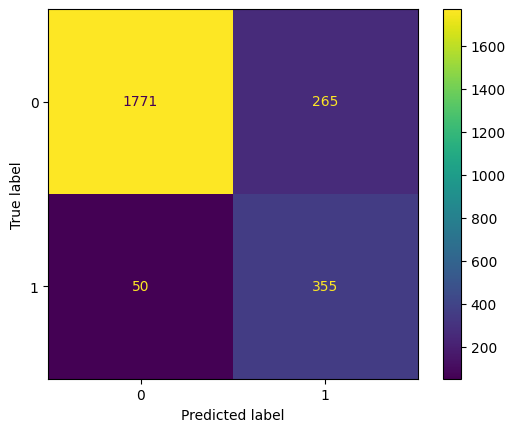

In [152]:
# Matriz de confusión

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusion
cm1= confusion_matrix(y_test, xgb.predict(X_test))
# Visualización de la matriz de confusion
cm1_display = ConfusionMatrixDisplay(confusion_matrix = cm1)
cm1_display.plot()
plt.show()

# Modelo 7: XGB Classifier Tunnig de hiperparametros

In [154]:
# Cuadricula de hiperparametros

parametersXGB = {'learning_rate': [0.05, 0.1,0.3],
              'max_features': [2, 4, 6, 8],
              'max_depth': [4,6,8,10,12],
              'n_estimators': [80, 100, 150, 200]}

In [160]:
ranfor_xgb = XGBClassifier(random_state = 142)

SearchCV_XGB = RandomizedSearchCV(
    ranfor_xgb,
    parametersXGB,
    scoring='f1',
    cv=5,
    n_jobs=-1
)

# Iniciamos la busqueda
grid_result = SearchCV_XGB.fit(X_sub, y_sub)

print('Mejores Hiperparámetros: ', grid_result.best_params_)
print('Mejor Score: ', grid_result.best_score_)

Mejores Hiperparámetros:  {'n_estimators': 200, 'max_features': 8, 'max_depth': 6, 'learning_rate': 0.3}
Mejor Score:  0.7665743575182306


In [161]:
# Métricas de desempeño
ranfor_optimo_XGB = grid_result.best_estimator_
print ("Train - Accuracy :", metrics.accuracy_score(y_train, ranfor_optimo_XGB.predict(X_train)))
print ("Train - classification report:\n", metrics.classification_report(y_train, ranfor_optimo_XGB.predict(X_train), digits=4))
print ("Test - Accuracy :", metrics.accuracy_score(y_test, ranfor_optimo_XGB.predict(X_test)))
print ("Test - classification report:\n", metrics.classification_report(y_test, ranfor_optimo_XGB.predict(X_test), digits=4))

Train - Accuracy : 0.8763826300696436
Train - classification report:
               precision    recall  f1-score   support

           0     0.9996    0.8543    0.9212      8261
           1     0.5547    0.9980    0.7131      1503

    accuracy                         0.8764      9764
   macro avg     0.7772    0.9261    0.8172      9764
weighted avg     0.9311    0.8764    0.8892      9764

Test - Accuracy : 0.891028267103646
Test - classification report:
               precision    recall  f1-score   support

           0     1.0000    0.8694    0.9301      2036
           1     0.6036    1.0000    0.7528       405

    accuracy                         0.8910      2441
   macro avg     0.8018    0.9347    0.8414      2441
weighted avg     0.9342    0.8910    0.9007      2441



### RESUMEN: Captura de resultado "Recall" de los modelos anteriores

In [157]:
def calcular_recall_para_modelos(model_name, modelos, conjuntos_X, conjuntos_X_test, objetivos_y_train, objetivos_y_test):
    train_recalls = []
    test_recalls = []

    for clf, X, X_test, y_train, y_test in zip(modelos, conjuntos_X, conjuntos_X_test, objetivos_y_train, objetivos_y_test):
        train_recall = recall_score(y_train, clf.predict(X))
        test_recall = recall_score(y_test, clf.predict(X_test))
        train_recalls.append(train_recall)
        test_recalls.append(test_recall)

    df = pd.DataFrame({
        'Modelo': model_name,
        'Train Recall': train_recalls,
        'Test Recall': test_recalls
    })

    return df

# Utiliza la función con tus modelos y datos
model_name = ["Modelo DTC","RandomForestClassifier","Tunning de Random FC","GradientBoostingClassifier", "Tunning GBC", "XGB Classifier", "Tunning XGB"]
modelos = [clf_2, ranfor, ranfor_optimo, gboos, ranfor_optimo_GBC, xgb, ranfor_optimo_XGB]
conjuntos_X = [X_train, X_train, X_train, X_train, X_train, X_train, X_train]
conjuntos_X_test = [X_test, X_test, X_test, X_test, X_test, X_test, X_test]
y_train_list = [y_train, y_train, y_train, y_train, y_train, y_train, y_train]  # Lista de y_train para cada modelo
y_test_list = [y_test, y_test, y_test, y_test, y_test, y_test, y_test]  # Lista de y_test para cada modelo

df_recall_final = calcular_recall_para_modelos(model_name, modelos, conjuntos_X, conjuntos_X_test, y_train_list, y_test_list)
df_recall_final

,Modelo,Train Recall,Test Recall
0,Modelo DTC,0.866933,0.849383
1,RandomForestClassifier,0.848303,0.829630
2,Tunning de Random FC,0.842315,0.829630
3,GradientBoostingClassifier,0.898869,0.898765
4,Tunning GBC,1.000000,1.000000
5,XGB Classifier,0.880240,0.876543
6,Tunning XGB,0.997339,1.000000


# Resultado y conclusiones:

Basandonos en la metrica de "Recall" para la clase positiva, se presentan las siguientes analisis y conclusión final, despues de realizar los modelos anteriores:

* GradientBoostingClassifier obtuvo la puntuación de recall más alta tanto en el conjunto de entrenamiento (aproximadamente 89.89%) como en el conjunto de prueba (aproximadamente 89.88%). Esto sugiere que este modelo generaliza bien y tiene un buen rendimiento tanto en datos conocidos como en datos desconocidos, lo que indica una capacidad robusta de generalización.

* XGB Classifier también mostró un rendimiento sólido, con una puntuación de recall cercana en ambos conjuntos de datos (alrededor del 88% en el conjunto de entrenamiento y 87.65% en el conjunto de prueba). Aunque ligeramente inferior al GradientBoostingClassifier, sigue siendo una opción prometedora.

* DecisionTreeClassifier (DTC) y Tunning de Random FC (RandomForestClassifier) también demostraron un rendimiento decente en ambas métricas de recall, aunque ligeramente inferiores a los modelos anteriores. Esto sugiere que estos modelos pueden ser considerados como opciones viables, especialmente si se tienen en cuenta otros factores como la interpretabilidad del modelo y los recursos computacionales requeridos.

* Tunning GBC (GradientBoostingClassifier) y Tunning XGB (XGB Classifier), muestra una puntuación de recall muy alta de 1.0 tanto en el conjunto de entreamiento como de prueba, por lo que se podria decir que el modelo esta sobreajustado (overfitting).

Por lo tanto concluimos que los modelos ajustados con hiperparámetros no siempre garantizan una mejora en el rendimiento del modelo y que el mejor modelo fue con GradientBoostingClassifier, siendo este el que arrojo una mejor metrica en sencibilidad pudiendo identicar en buena proporción las instancias positivas tanto con los datos de entrenamiento y como en los de prueba. Sin embargo, vimos que los modelos tienden a presentar dificultades para la clase minoritaria, siendo esta la de interes, por lo que se sugiere recopilar mas datos donde se tengan mas valores sobre la clase positiva y poder demerminar unas caracteristicas mucho mas completas y determinar patrones mas acertados para lograr el objetivo de precedir con buenos resultados el comportamiento en el comercio electronico.
